<center><h1>Machine Learning 2 task - Taxi Fare Prediction</h1></center>

<center>
  <h2>Table of contents:</h2>
    <h3>1. Project Overview</h3>
    <h3>2. Evaluation Metrics</h3>
    <h3>3. Exploratory Data Analysis</h3>
    <h3>4. Modelling
    <h3>5. Summary</h3>
</center>

### Project Overview
The goal of this project is to predict taxi fare amounts in `New-York` city, based on pick-up and drop-off locations and other factors. The data spans between `01-01-2014` to `30-06-2015`. We want to improve the predictions, that for simple predictions range between RMSE of 5$-8$ depending on the model used. 

### Evaluation Metrics
The evaluation metric for this task is the `RMSE` (root mean-squared error). RMSE measures the difference between the predictions of a model, and the corresponding ground truth. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better. The metric is particularly useful, because the error is given in the units being measured, so for our task we would know the average absolute error of the fare amount.

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

In [1]:
# for data manipluation pandas is used
# for ploting matplotlib and seaborn is used
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
schema = {
    "id": "uint32",
    "dropoff_latitude": "float64",
    "dropoff_longitude": "float64",
    "fare_amount": "float64",
    "feat1": "float64", # note: original data has feat01 name, but it is replaced for looping purposes
    "feat2": "float64",
    "feat3": "float64",
    "feat4": "float64",
    "feat5": "float64",
    "feat6": "float64",
    "feat7": "float64",
    "feat8": "float64",
    "feat9": "float64",
    "feat10": "float64",
    "key": "string",
    "passenger_count": "int16",
    "pickup_datetime": "string",
    "pickup_latitude": "float64",
    "pickup_longitude": "float64",
}

In [3]:
data = pd.read_csv("data/r3.csv", dtype=schema)
data.columns = schema.keys()
data.drop(columns="id", inplace=True) # we use key as index

### Exploratory Data Analysis

### Expectations:
- H1: feat features are not significant for fare amount predictions
- H2: fare amount has strongest correlation with the spatial features
- H3: peak hours (those with highest demand) reflect in higher average fare amount
- H4: weekends and free days have higher average fare amount

### Understanding feat features

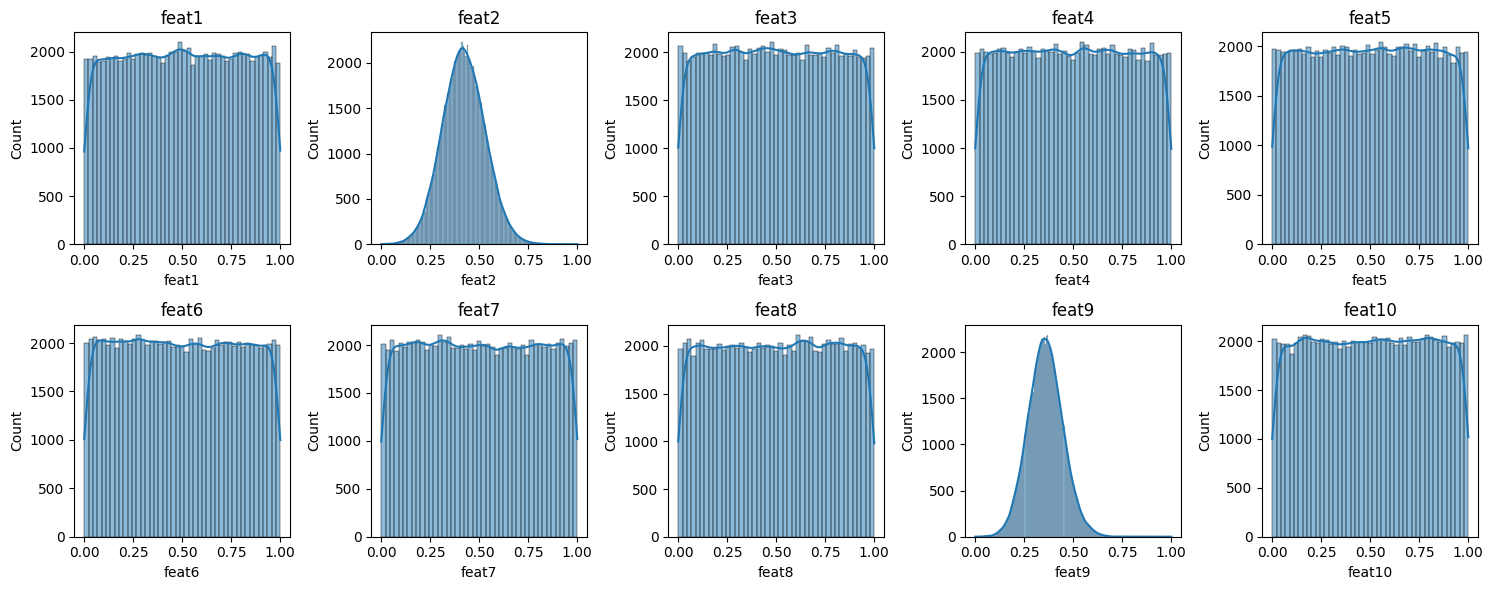

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(1, 11):
    sns.histplot(data[f'feat{i}'], ax=axes[i-1], kde=True)
    axes[i-1].set_title(f'feat{i}')

plt.tight_layout()
plt.show()

- the features `feat1`, `feat3`, `feat4`, `feat5`, `feat6`, `feat7`, `feat8`, `feat10` exibit a uniform distribution. The histograms show that the data is evenly spread across the entire range from - to 1.
- the features `feat2` and `feat9` exibit normal distribution. The histograms show a bell-shaped curve centered around 0.5 with the data tapering off symetrically towards the edges.

### Correlation

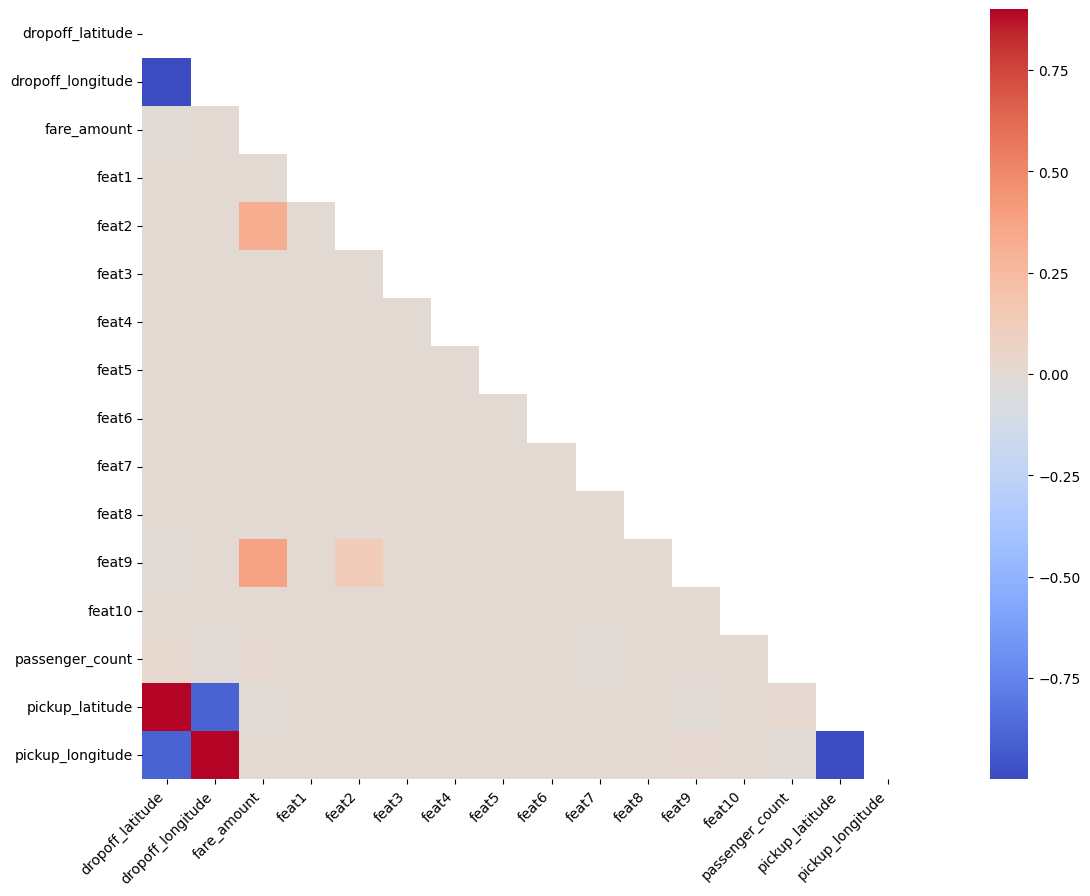

In [5]:
data_numeric = data.select_dtypes(include='number')
corr_matrix = data_numeric.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, mask=mask, cbar=True, square=True, 
            annot_kws={'size': 10}, cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.show()

### Data Transformations

We have a date column `pickup_datetime` from which we can extract many features: year, month, day_of_week, hour. Then in order to work with numerical data while keeping the periodic aspect of it we make `sine` and `cosine` transormations of the variables. That way we ensure the numerical variables wont dominate when other features are scaled, and we keep the seasonal patterns.

In [6]:
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format="%Y-%m-%d %H:%M:%S %Z")
data["pickup_datetime"] = data["pickup_datetime"].dt.tz_localize(None)

data["year"] = data["pickup_datetime"].dt.year
data["month"] = data["pickup_datetime"].dt.month
data["day_of_week"] = data["pickup_datetime"].dt.day_of_week
data["hour"] = data["pickup_datetime"].dt.hour

In [7]:
data["hour_sin"] = np.sin(2 * np.pi * data["hour"] / 24)
data["hour_cos"] = np.cos(2 * np.pi * data["hour"] / 24)

data["month_sin"] = np.sin(2 * np.pi * (data["month"] - 1) / 12)
data["month_cos"] = np.cos(2 * np.pi * (data["month"] - 1) / 12)

data["day_of_week_sin"] = np.sin(2 * np.pi * data["day_of_week"] / 7)
data["day_of_week_cos"] = np.cos(2 * np.pi * data["day_of_week"] / 7)

As we have date column, we can add a holiday to our variables, and a column which wwould indicate if the next day is free of work. For that we use python `holiday` package. If next day is firday or saturday, or next day is holiday we add this record to `is_next_day_free`.

In [8]:
import holidays

us_holidays = holidays.US(years=data["year"].unique())
def is_next_day_free(row):
    next_day = row["pickup_datetime"] + pd.Timedelta(days=1)
    if next_day.dayofweek in [4, 5]:
        return 1
    if next_day in us_holidays:
        return 1   
    return 0

data["is_next_day_free"] = data.apply(is_next_day_free, axis=1).astype(int)

The same date column can allow us to add oil prices, which can be informative predictor of car fuel being used in taxis in 2014 and 2015. We used
`oil price data` from `https://www.investing.com/commodities/crude-oil-historical-data` and merged it based on the date.

In [9]:
data["pickup_date"] = data["pickup_datetime"].dt.floor('D')

oil_data = pd.read_csv("data/oil.csv")
oil_data = oil_data[["Date", "Price"]]
oil_data["Date"] = pd.to_datetime(oil_data["Date"])
oil_data

# # merge oil data
data = pd.merge(data, oil_data, left_on="pickup_date", right_on="Date", how="left")
data.drop(columns=["pickup_date", "Date"], inplace=True)

The same date column can allow us to add weather conditions (min and max temperature, precipitation, snow, wind), which can also be an important predictors of fare amount. We used `weather data` from `https://www.kaggle.com/datasets/danbraswell/new-york-city-weather-18692022` and merged it based on the date

In [10]:
weather_data = pd.read_csv("data/weather.csv")
weather_data["DATE"] = pd.to_datetime(weather_data["DATE"])

weather_data["DATE"] = weather_data["DATE"].dt.date
data["pickup_datetime"] = data["pickup_datetime"].dt.date

data = pd.merge(data, weather_data, left_on="pickup_datetime", right_on="DATE", how="left")
data.drop(columns=["DATE"], inplace=True)

We can now inspect how the demand shapes through out the day. For all days, no matter if the next is free the distribution is nearly the same. We see peek hours between `18-22`, where the demand is over `5000` pick-ups each

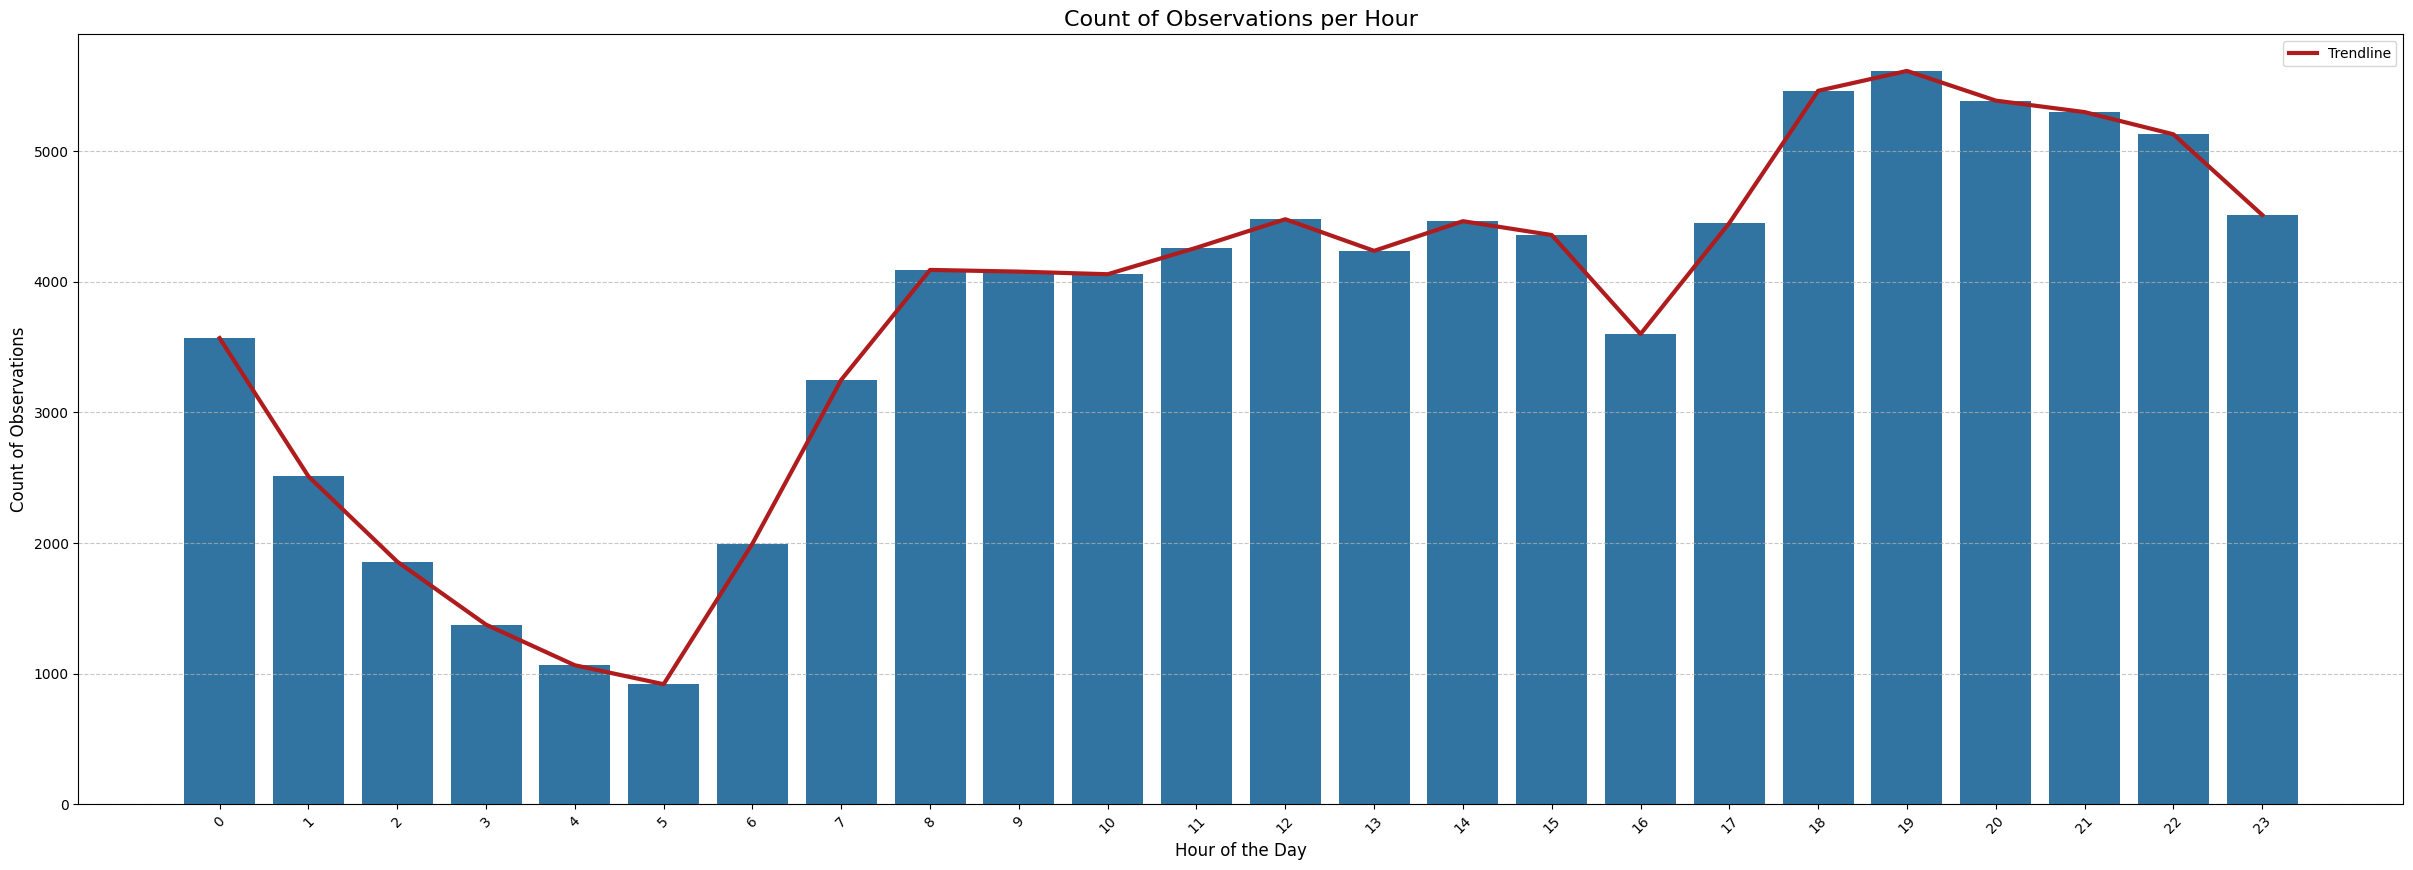

In [11]:
hourly_counts = data["hour"].value_counts().sort_index()

plt.figure(figsize=(30, 10))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='#1f77b4')
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, color='#af1c1e', linewidth=3, label='Trendline')
plt.title("Count of Observations per Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Count of Observations", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

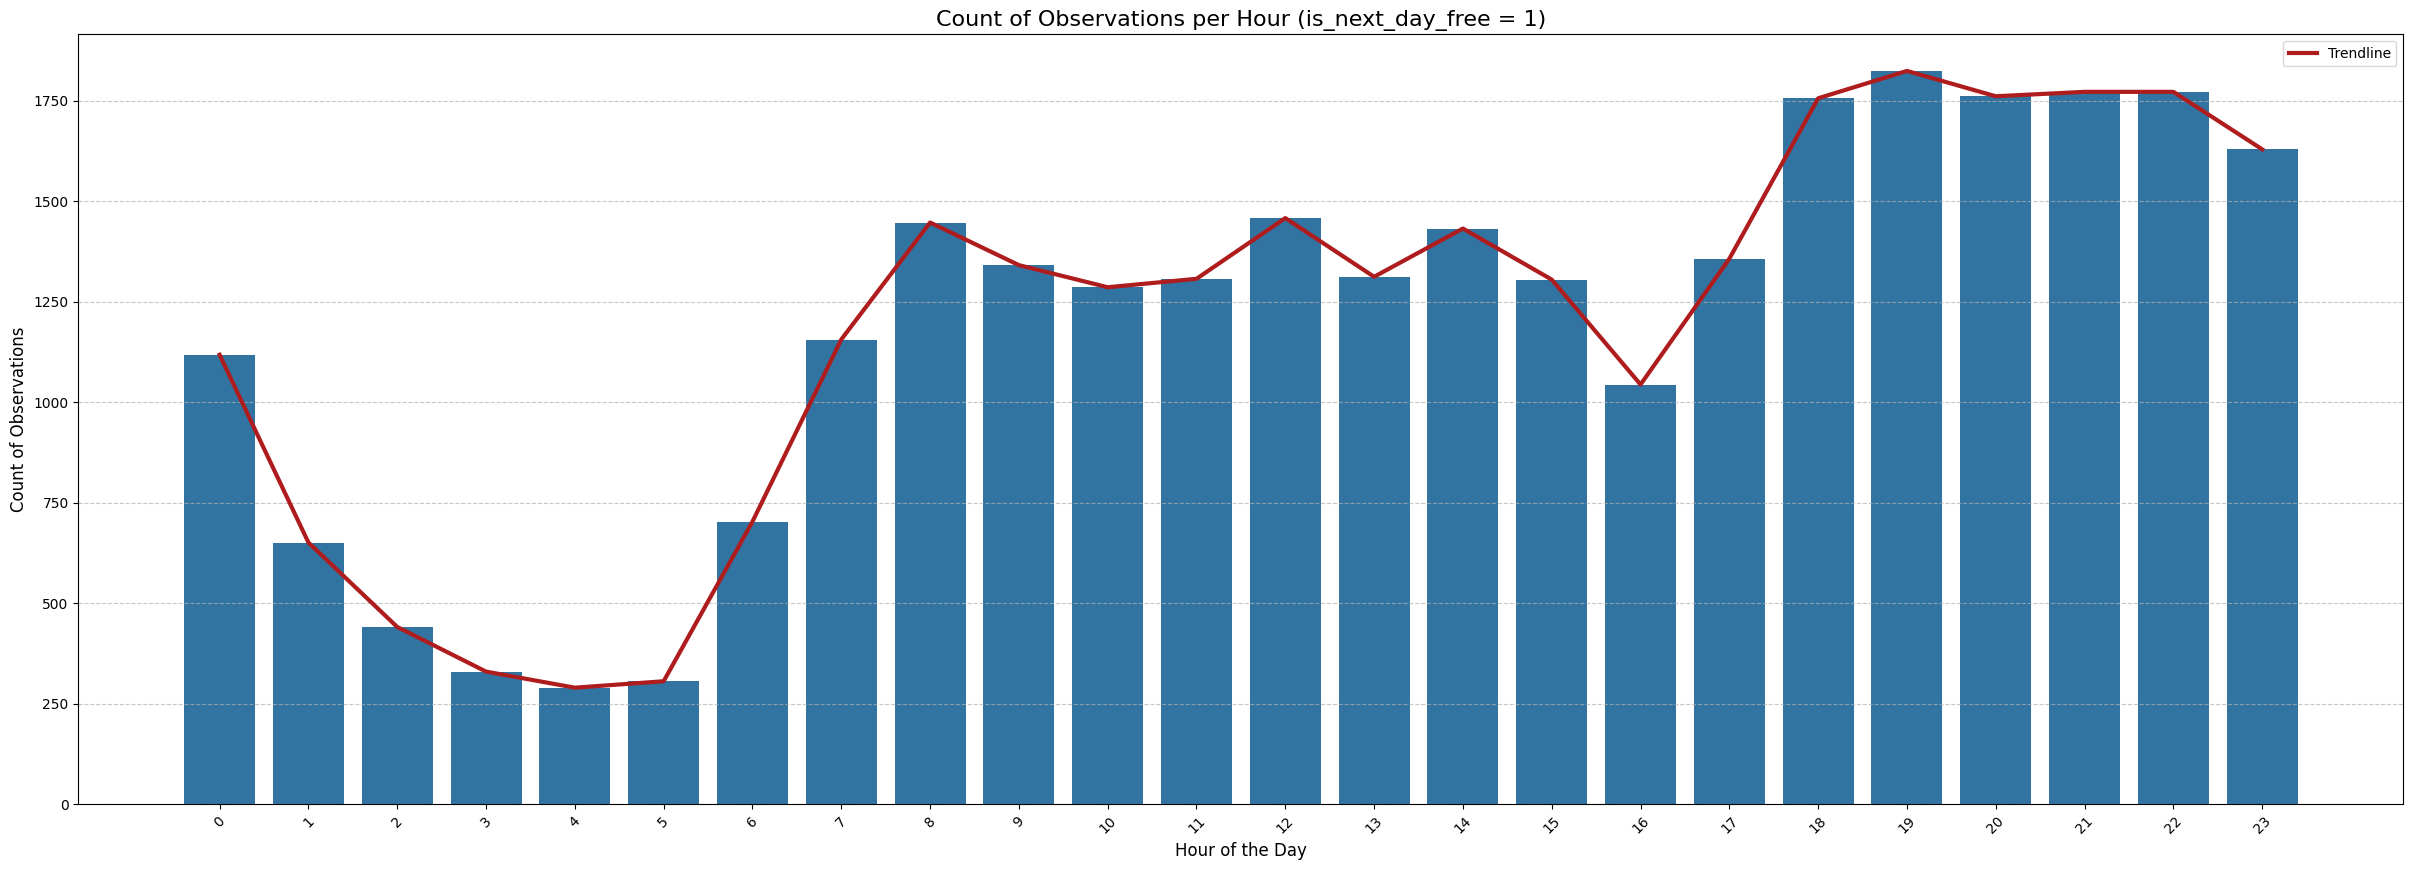

In [12]:
# same plot but for days that are free the next day
filtered_data = data[data["is_next_day_free"] == 1]
hourly_counts = filtered_data["hour"].value_counts().sort_index()

plt.figure(figsize=(30, 10))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='#1f77b4')
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, color='#af1c1e', linewidth=3, label='Trendline')
plt.title("Count of Observations per Hour (is_next_day_free = 1)", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Count of Observations", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

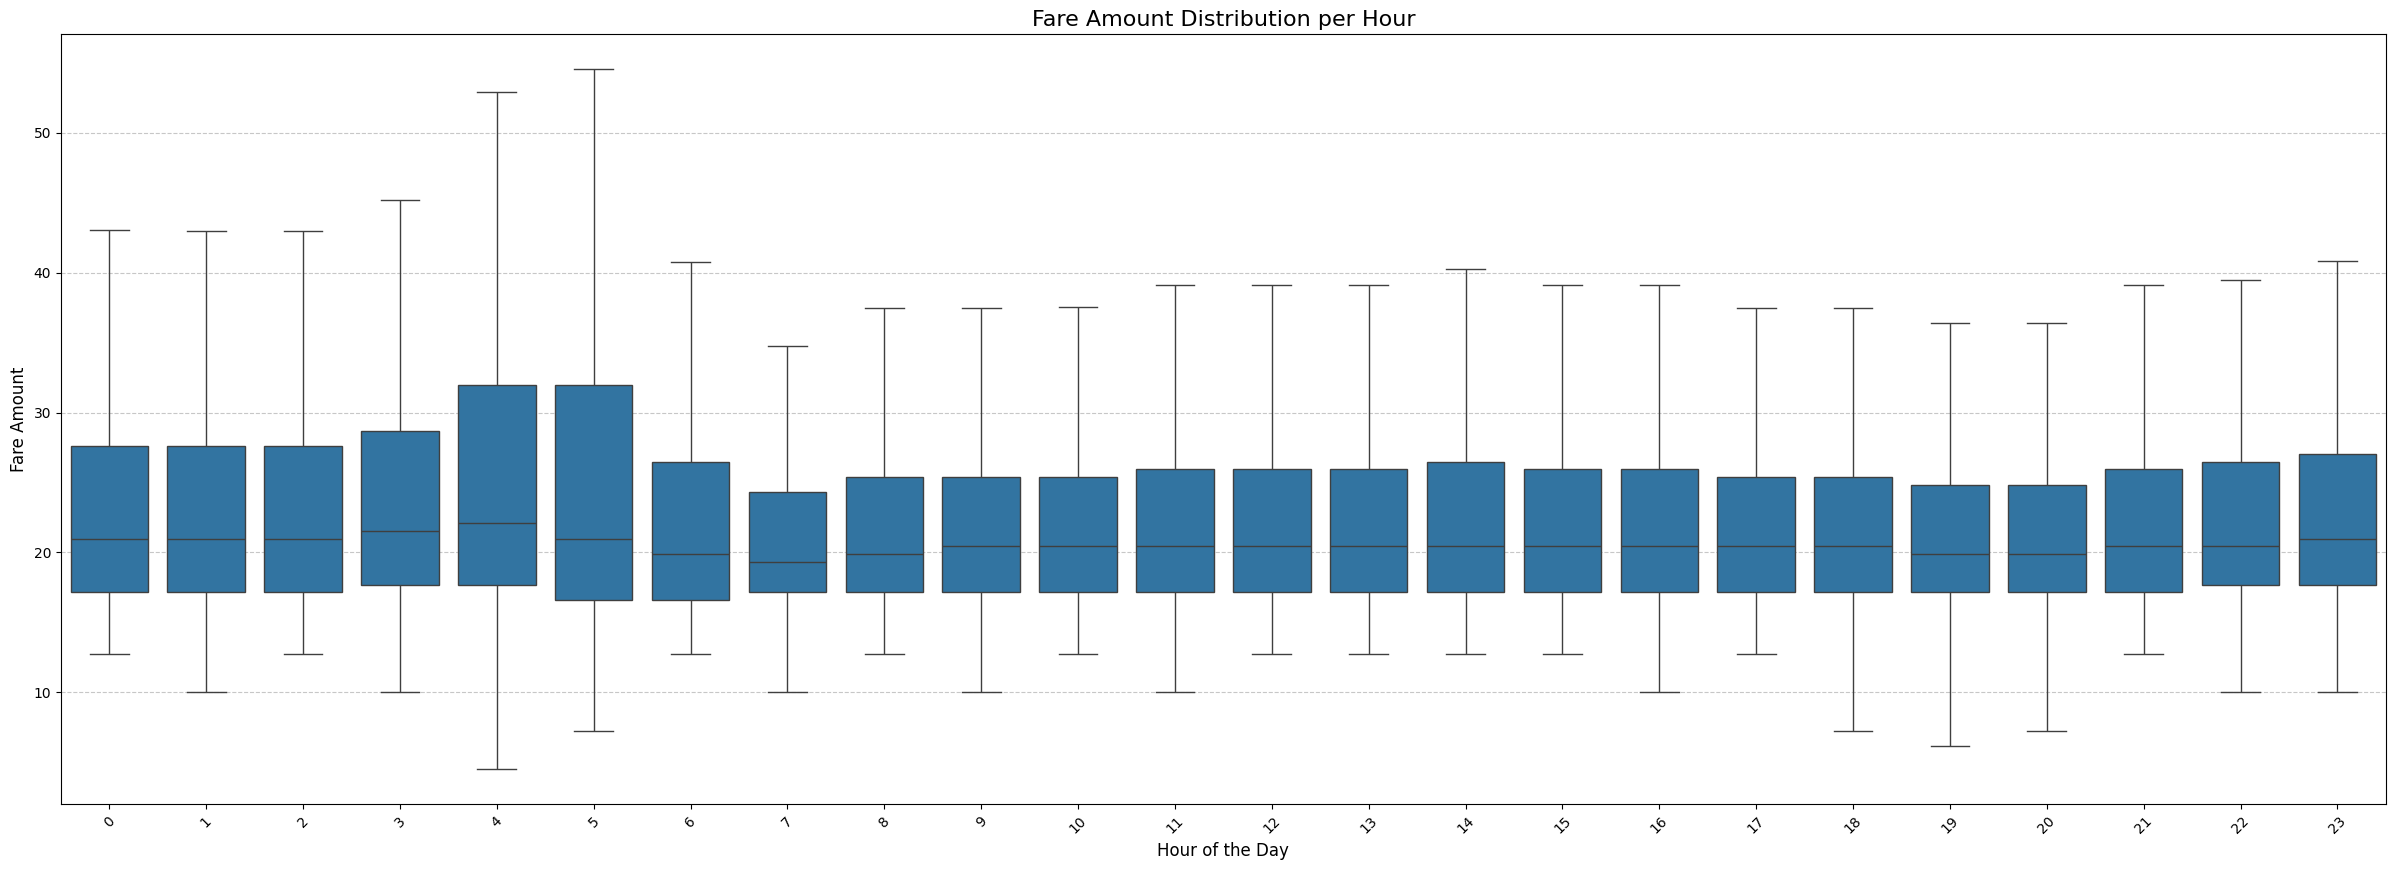

In [13]:
# plot the distribution of fare_amount with respect to hour
plt.figure(figsize=(30, 10))
sns.boxplot(x="hour", y="fare_amount", data=data, showfliers=False, color='#1f77b4')
plt.title("Fare Amount Distribution per Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Fare Amount", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

We see that the median value is nearly same through the whole day, with an increase in early hours `3-5` which actually are the lowest demand hours. During those hours also the quartiles are bigger, indicating a more fluctuations in the prices. Besides that the peek hours do not indicate any significant change in fare amount, nevertheless we create a variable out of them, where 1 indicates hours between `18-22` and others are 0

In [14]:
data["peak_hour"] = ((data["hour"] >= 18) & (data["hour"] <= 22)).astype(int)
data.drop(columns=["hour", "month", "day_of_week", "year"], inplace=True)

In [15]:
#calculate distance between pickup and dropoff
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

data["distance_km"] = haversine_distance(
    data["pickup_latitude"], data["pickup_longitude"],
    data["dropoff_latitude"], data["dropoff_longitude"]
)

In [16]:
# # remove outliers based on longitude and latitude that are outside of NYC
data = data[(data["pickup_latitude"] > 35) & (data["pickup_latitude"] < 44)]
data = data[(data["pickup_longitude"] < -70) & (data["pickup_longitude"] > -78)]
data = data[(data["dropoff_latitude"] > 35) & (data["dropoff_latitude"] < 44)]
data = data[(data["dropoff_longitude"] < -70) & (data["dropoff_longitude"] > -78)]

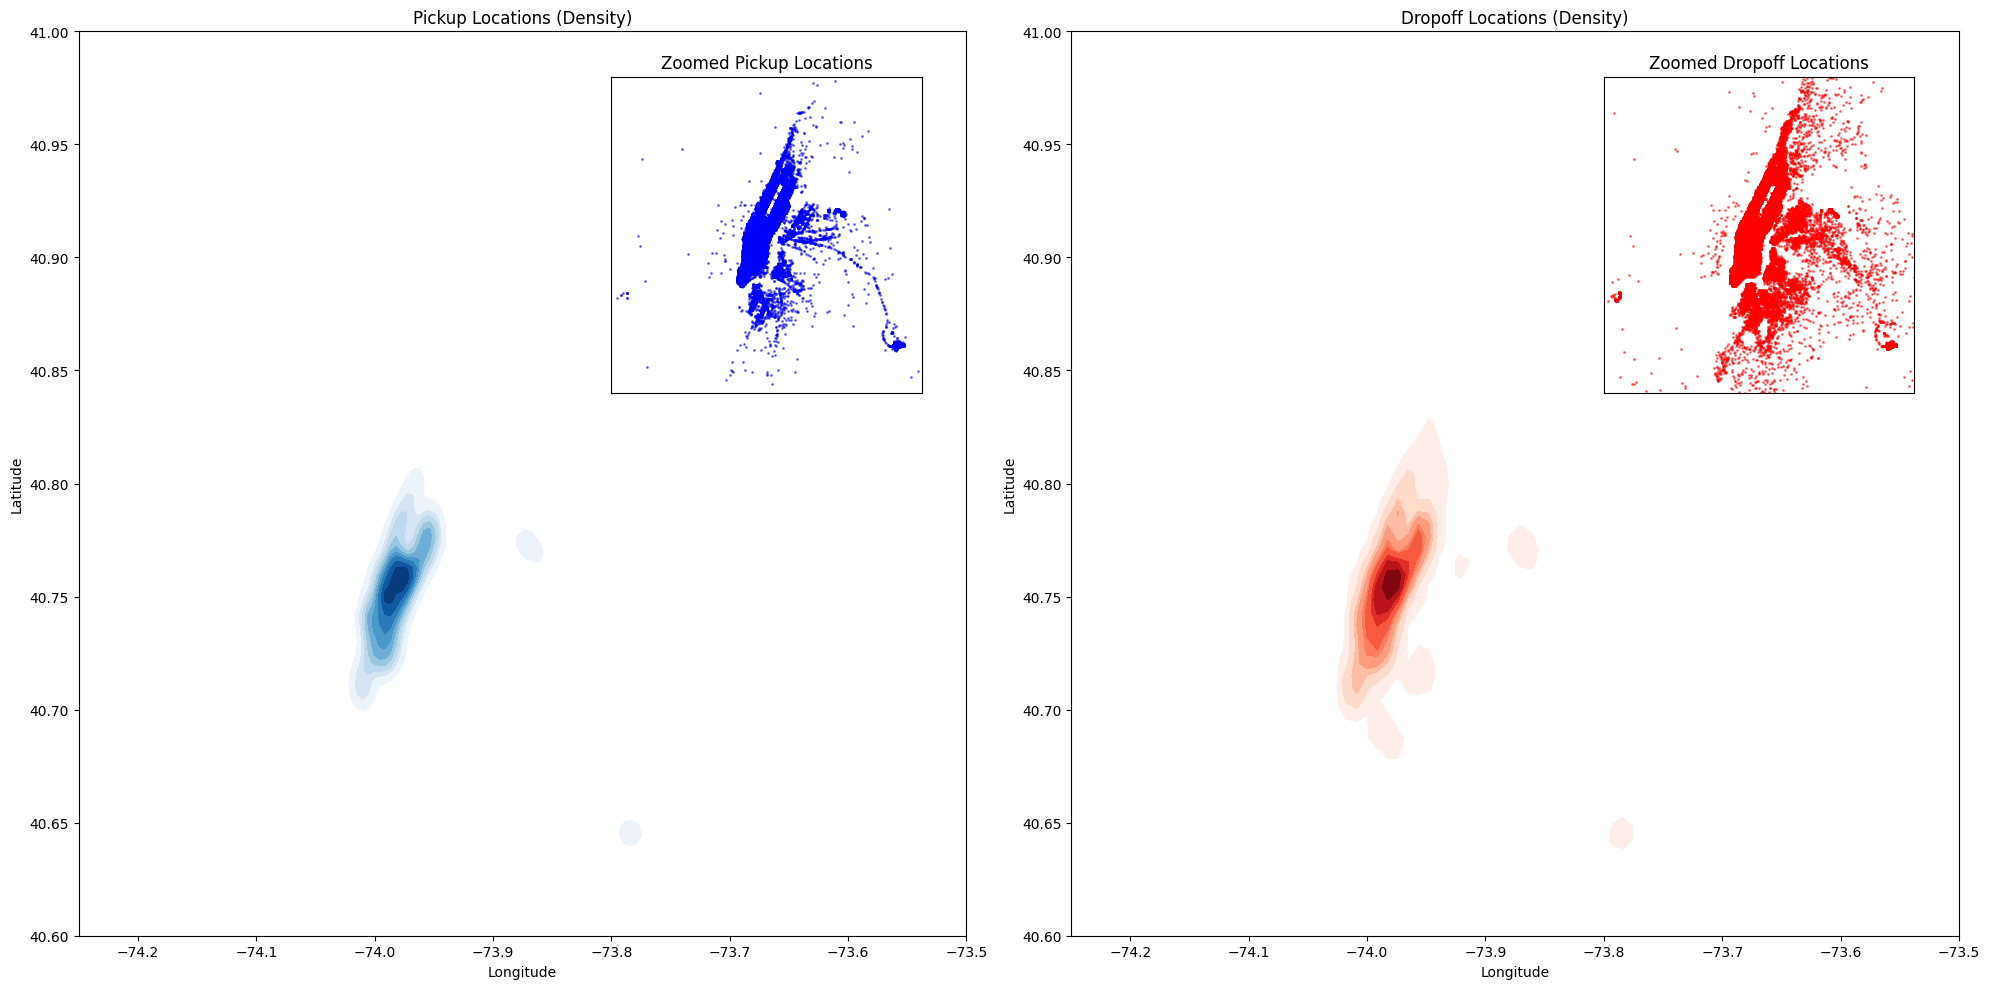

In [17]:
x_range_zoom = (-74.2, -73.75)
y_range_zoom = (40.6, 40.9)
x_range_full = (-74.25, -73.5)
y_range_full = (40.6, 41)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.kdeplot(
    x=data["pickup_longitude"],
    y=data["pickup_latitude"],
    fill=True,
    thresh=0.1,
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_title("Pickup Locations (Density)")
axes[0].set_xlim(x_range_full)
axes[0].set_ylim(y_range_full)

ax_zoom_pickup = axes[0].inset_axes([0.6, 0.6, 0.35, 0.35])
ax_zoom_pickup.scatter(data["pickup_longitude"], data["pickup_latitude"], s=1, color="blue", alpha=0.5)
ax_zoom_pickup.set_xlim(x_range_zoom)
ax_zoom_pickup.set_ylim(y_range_zoom)
ax_zoom_pickup.set_title("Zoomed Pickup Locations")
ax_zoom_pickup.set_xticks([])
ax_zoom_pickup.set_yticks([])

sns.kdeplot(
    x=data["dropoff_longitude"],
    y=data["dropoff_latitude"],
    fill=True,
    thresh=0.1,
    cmap="Reds",
    ax=axes[1]
)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_title("Dropoff Locations (Density)")
axes[1].set_xlim(x_range_full)
axes[1].set_ylim(y_range_full)

ax_zoom_dropoff = axes[1].inset_axes([0.6, 0.6, 0.35, 0.35])
ax_zoom_dropoff.scatter(data["dropoff_longitude"], data["dropoff_latitude"], s=1, color="red", alpha=0.5)
ax_zoom_dropoff.set_xlim(x_range_zoom)
ax_zoom_dropoff.set_ylim(y_range_zoom)
ax_zoom_dropoff.set_title("Zoomed Dropoff Locations")
ax_zoom_dropoff.set_xticks([])
ax_zoom_dropoff.set_yticks([])

plt.tight_layout()
plt.show()

We can see three areas on the graph based on the density. Lets recalculate them and use as categorical variables. The most dense areas will be `center`, then we have `city`, and lastly `suburbs` for less dense areas. It is clear that most pick-ups are within center areas while much more drop-offs happen in the suburbs

In [18]:
density_thresholds = {
    "center": 0.9,
    "suburbs": 0.2,
    "city": 0.2
}

def assign_density_categories(data, lon_col, lat_col, thresholds):
    coords = np.vstack([data[lon_col], data[lat_col]])
    kde = gaussian_kde(coords)
    densities = kde(coords)
    
    normalized_densities = (densities - densities.min()) / (densities.max() - densities.min())
    
    categories = []
    for density in normalized_densities:
        if density >= thresholds["center"]:
            categories.append("center")
        elif density <= thresholds["suburbs"]:
            categories.append("suburbs")
        else:
            categories.append("city")
    
    return categories

data["pickup_area"] = assign_density_categories(data, "pickup_longitude", "pickup_latitude", density_thresholds)
data["dropoff_area"] = assign_density_categories(data, "dropoff_longitude", "dropoff_latitude", density_thresholds)

pickup_area_dummies = pd.get_dummies(data["pickup_area"], prefix="pickup_area").astype(int)
dropoff_area_dummies = pd.get_dummies(data["dropoff_area"], prefix="dropoff_area").astype(int)

data = pd.concat([data, pickup_area_dummies, dropoff_area_dummies], axis=1)

### Boroughts of New York

To add further on the geospatial data we can introduce New York Boroughts (areas) using data from `https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm`. This simply adds another layer of bins on top of the longtitude and latitute columns

In [19]:
boroughs = gpd.read_file("data/nyc_areas.geojson")

data['pickup_point'] = data.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
data['dropoff_point'] = data.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

gdf = gpd.GeoDataFrame(data, geometry='pickup_point')

In [20]:
gdf.set_crs(epsg=4326, inplace=True)
boroughs.set_crs(epsg=4326, inplace=True)

pickup_boroughs = gpd.sjoin(gdf, boroughs, how="left", predicate="within")
pickup_boroughs.rename(columns={'boro_name': 'pickup_borough'}, inplace=True)

gdf.set_geometry('dropoff_point', inplace=True)
dropoff_boroughs = gpd.sjoin(gdf, boroughs, how="left", predicate="within")
dropoff_boroughs.rename(columns={'boro_name': 'dropoff_borough'}, inplace=True)

data['pickup_borough'] = pickup_boroughs['pickup_borough'].fillna("Unknown")
data['dropoff_borough'] = dropoff_boroughs['dropoff_borough'].fillna("Unknown")

pickup_dummies = pd.get_dummies(data['pickup_borough'], prefix='pickup').astype(int)
dropoff_dummies = pd.get_dummies(data['dropoff_borough'], prefix='dropoff').astype(int)

data = pd.concat([data, pickup_dummies, dropoff_dummies], axis=1)

### Distance to Landmarks

We can also add columns that would represent distances from the most popular Landmarks of New York. We calculate the distance between each of the landmarks and the pickup point as an indicator of popularity of that area. The longtitude and latitude were taken from `https://www.latlong.net/`

In [21]:
landmarks = {
    'Times Square': {'latitude': 40.7589, 'longitude': -73.9851},
    'Central Park': {'latitude': 40.7850, 'longitude': -73.9682},
    'Empire State Building': {'latitude': 40.7488, 'longitude': -73.9854},
    'Statue of Liberty': {'latitude': 40.6892, 'longitude': -74.0445},
    'JFK Airport': {'latitude': 40.6417, 'longitude': -73.7809},
    'Grand Central Terminal': {'latitude': 40.7526, 'longitude': -73.9772},
    'Brooklyn Bridge': {'latitude': 40.7060, 'longitude': -73.9970},
    'Yankee Stadium': {'latitude': 40.8296, 'longitude': -73.9261},
    'Coney Island': {'latitude': 40.5755, 'longitude': -73.9707},
    'Rockefeller Center': {'latitude': 40.7587, 'longitude': -73.9787}
}

In [22]:
for landmark, coords in landmarks.items():
    data[f'distance_pickup_{landmark}'] = data.apply(
        lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], coords['latitude'], coords['longitude']),
        axis=1
    )

In [23]:
data.rename(columns={"Price": "oil_price"}, inplace=True)

data.sort_values(by='pickup_datetime', inplace=True)
data.drop(columns=["pickup_datetime", "pickup_area", "dropoff_area", "pickup_point", "dropoff_point", "pickup_borough", "dropoff_borough"], inplace=True)
data["oil_price"].fillna(method='ffill', inplace=True)

### Correlation Matrix

The correlation matrix show that `fare_amount` is strongly positively correlated with `distance_km`, as well as the `suburbs` area (probably because most of longer rides are from center to suburbs). We see also negative correlation with the less dence areas (city). There is quite strong correlation with the `feat2` and `feat9` features. Surprisingly no weather data, nor calendar data seem to influence the fare_amount. Additonally the distance from landmarks has positive impact on the fare_amount.

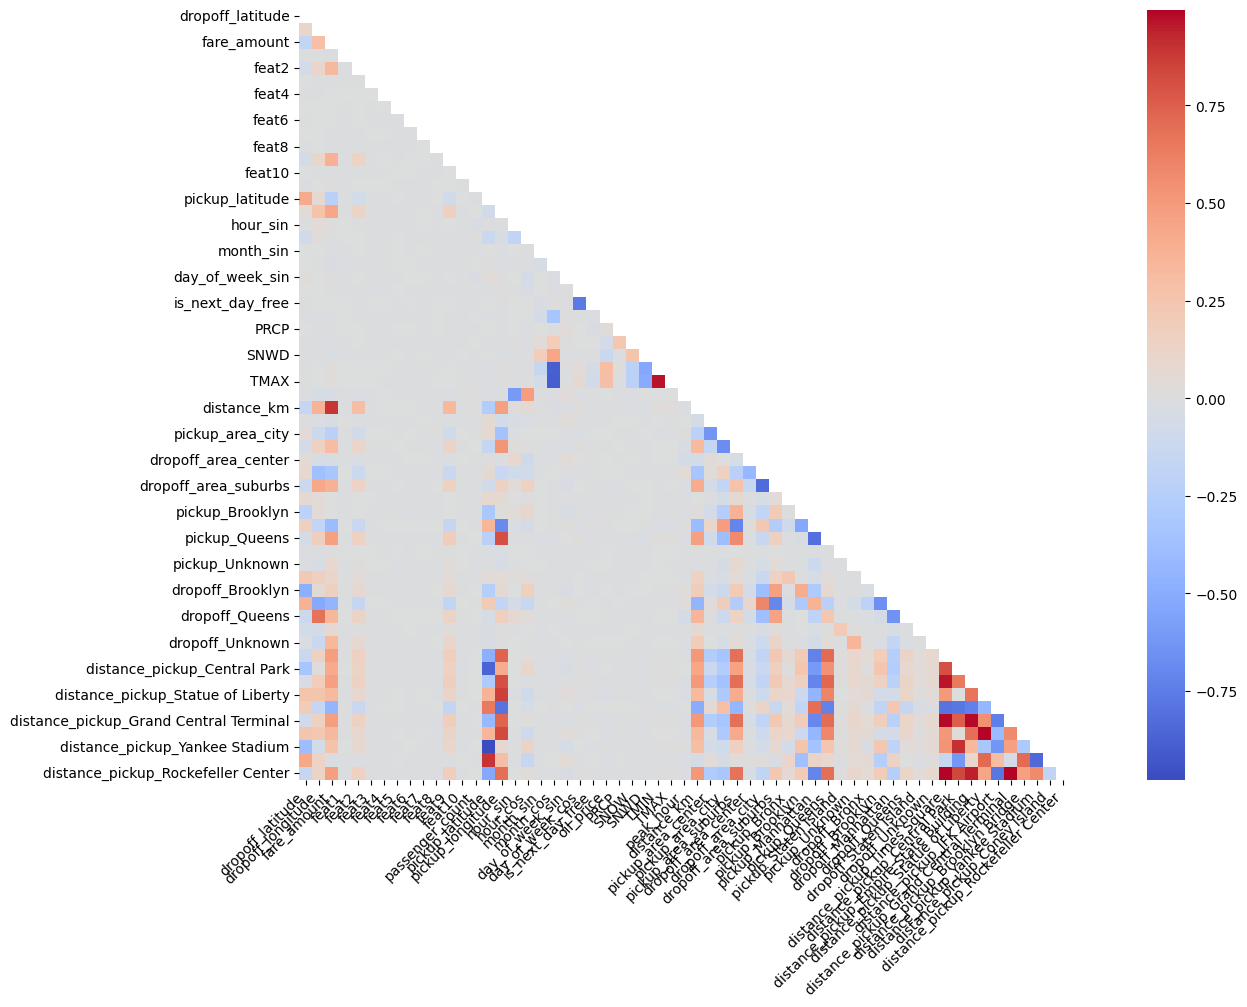

In [24]:
data_numeric = data.select_dtypes(include='number')
corr_matrix = data_numeric.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, mask=mask, cbar=True, square=True, 
            annot_kws={'size': 10}, cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.show()

### Modelling

To predict the fare amount I implemented `XGBoost` and `Neural Network` approaches. Both are cross validated, and their parameters are tuned  using random seatch. Whole project used XGBoost python package for xgb model, tensorflow for Neural networks, and scikit-learn as a metrics/modelling package

*NOTE: The project setting did not specify wether the test data is of future or not, we performed the cross validation in two approaches. The first one uses TimeSeriesSplit which ensures we test out model only on data from the future, and the other approach is on KFold splits which works as a normal cross validation for regression.

### XGBoost

In [25]:
import numpy as np
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split, KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers
import tensorflow as tf
from kerastuner import Objective
from kerastuner.tuners import BayesianOptimization

import xgboost as xgb

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [26]:
X = data.drop(columns=["fare_amount", "key"])
y = data["fare_amount"]

In [27]:
# all numerical variables that are sensible to be standardized.
# we exculde the target variable and the key, binary variables and trigonomatric transformed variables
features_to_scale = [
    "distance_km", 
    "distance_pickup_Times Square",
    "distance_pickup_Central Park",
    "distance_pickup_Empire State Building",
    "distance_pickup_Statue of Liberty",
    "distance_pickup_JFK Airport",
    "distance_pickup_Grand Central Terminal",
    "distance_pickup_Brooklyn Bridge",
    "distance_pickup_Yankee Stadium",
    "distance_pickup_Coney Island",
    "distance_pickup_Rockefeller Center",
    "oil_price", 
    "passenger_count", 
    "feat1", 
    "feat2", 
    "feat3", 
    "feat4", 
    "feat5", 
    "feat6", 
    "feat7", 
    "feat8", 
    "feat9", 
    "feat10",
    "TMIN",
    "TMAX",
    "PRCP",
    "SNOW",
    "SNWD",
]

In [28]:
# to prevent data leakage, we standardize the training and validation sets separately.
# fit_transform on the training set and transform on the validation set.

def standardize_train_val(X_train, X_val, features_to_scale):
    """
    Standardize the training and validation sets separately to prevent data leakage.

    Parameters:
    - X_train: DataFrame, training features
    - X_val: DataFrame, validation features
    - features_to_scale: list, names of the features to be standardized

    Returns:
    - X_train_scaled: DataFrame, standardized training features
    - X_val_scaled: DataFrame, standardized validation features
    """
    scaler = StandardScaler()

    X_train.loc[:, features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_val.loc[:, features_to_scale] = scaler.transform(X_val[features_to_scale])
    
    return X_train, X_val

to properly measure each model and regression performance I created custom cross validation functions, and evaluated the model with 10 folds. Cross validation helps assesing the model performance multiple time on the data not seen before. It divides the data into bins: test and train, calcualtes the statistics with functions defined earlier. Then it startes again, by taking another bin as a validation set and training model with the remaining bins. In the codes there are 2 simmilar functions for XGBoost and Neural Networks, as the models use different random search and hyperparameters.

In [29]:
def cross_validate_random_search_xgboost(X, y, param_dist, features_to_scale, cv=5, n_iter=10, random_state=42):
    """
    Cross-validate a Random Search XGBoost model using TimeSeriesSplit and calculate RMSE.

    Parameters:
    - X: DataFrame, features
    - y: Series, target variable
    - features_to_scale: list, names of the features to be standardized
    - cv: int, number of cross-validation folds
    - n_iter: int, number of iterations for Random Search
    - random_state: int, random seed for reproducibility

    Returns:
    - best_params: dict, best hyperparameters found
    - best_rmse: float, best RMSE score
    """
    tscv = TimeSeriesSplit(n_splits=cv)
    #tscv = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    rmse_scores = []
    param_sets = []

    for i in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_dist.items()}
        param_sets.append(params)

    for params in param_sets:
        fold_rmse_scores = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            X_train, X_test = standardize_train_val(X_train, X_test, features_to_scale)

            model = xgb.XGBRegressor(**params, random_state=random_state)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, y_pred)
            fold_rmse_scores.append(rmse)

        mean_rmse = np.mean(fold_rmse_scores)
        rmse_scores.append(mean_rmse)

        #NOTE Uncomment to see RMSE for each cross-validated set of parameters
        # print(f"Hyperparameters: {params}")
        # print(f"Mean RMSE: {mean_rmse}")
        # print("-" * 50)

    best_index = np.argmin(rmse_scores)
    best_params = param_sets[best_index]
    best_rmse = rmse_scores[best_index]

    return best_params, best_rmse

In [30]:
# set of hyperparameters for Random Search
param_dist_xgb = {
    'n_estimators': list(range(100, 501, 50)),
    'learning_rate': np.linspace(0.01, 0.2, 10).tolist(),
    'max_depth': list(range(3, 11)),
    'subsample': np.linspace(0.6, 1.0, 25).tolist(),
    'colsample_bytree': np.linspace(0.6, 1.0, 25).tolist(),
    'gamma': np.linspace(0, 0.4, 25).tolist(),
    'min_child_weight': list(range(1, 11)),
    'reg_alpha': np.linspace(0, 0.2, 25).tolist(),
    'reg_lambda': np.linspace(1.0, 5.0, 25).tolist(),
}

In [31]:
best_params, best_rmse = cross_validate_random_search_xgboost(X, y, 
                    param_dist=param_dist_xgb, 
                    features_to_scale=features_to_scale, 
                    cv=10, n_iter=200, random_state=42)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validated RMSE: {best_rmse}")

Best Hyperparameters: {'n_estimators': 400, 'learning_rate': 0.07333333333333333, 'max_depth': 7, 'subsample': 0.8333333333333333, 'colsample_bytree': 0.7666666666666666, 'gamma': 0.11666666666666667, 'min_child_weight': 5, 'reg_alpha': 0.05, 'reg_lambda': 4.0}
Best Cross-Validated RMSE: 4.134062592322105


The TimeSeriesSplit cross validation resulted in best RMSE of `4.13$` while the best with KFold cross validation indicated `3.99$`. It is a slight improvement in comparison with the 5$-8$ said in a task to be a barrier to beat. The cross validation of the results ensures us, that the model would probably behave and predict new data with similar accuracy to the data it was trained on. We can interpret the results as follows:

<b>RMSE</b> - The predicted fare amount is on average different from the actual value by `3.99$`. As majority of the fares is relatively low (median = 21$) this error is substantial.

### Neural Networks

In [32]:
# get number of input neurons
input_shape = X.shape[1]
input_shape

58

In [33]:
# the build_model function is used to create models with different hyperparameters. It is used by the BayesianOptimization tuner.
# each iteration of the tuner will call this function with a different set of hyperparameters.
# we allow the model to choose between 3 and 10 hidden layers, with each layer having between 8 and 1024 units.
# the number of neurons being a power of 2 increases the performance, as most hardware operations are performed in powers of 2.
def build_model(hp):
    model = tf.keras.Sequential()
    input_shape = X.shape[1]
    
    model.add(layers.Dense(input_shape, input_shape=(input_shape,), activation='relu', name="input_layer"))
    
    num_layers = hp.Int('num_layers', 3, 10)
    #print(f"Number of hidden layers: {num_layers}")
    
    for i in range(num_layers):
        units = hp.Choice(f'units_{i}', values=[8, 16, 32, 64, 128, 256, 512, 1024])
        activation = hp.Choice(f'activation_{i}', values=['relu', 'gelu', 'linear', 'leaky_relu'])
        model.add(layers.Dense(units=units, activation=activation))
        #print(f"Added hidden layer {i+1} with {units} units and '{activation}' activation.")
    
    model.add(layers.Dense(1, activation=None, name="output_layer"))
    
    learning_rate = hp.Choice('learning_rate', [1.5e-2, 1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

In [34]:
def bayesian_optimization_neural_net(X, y, features_to_scale, n_iter=10, random_state=42):
    """
    Use Bayesian Optimization to find the best neural network architecture and hyperparameters.

    Parameters:
    - X: DataFrame, features
    - y: Series, target variable
    - features_to_scale: list, names of the features to be standardized
    - n_iter: int, number of iterations for Bayesian Optimization
    - random_state: int, random seed for reproducibility

    Returns:
    - best_model: tf.keras.Model, the best model found
    - best_hyperparameters: dict, best hyperparameters found
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_train, X_test = standardize_train_val(X_train, X_test, features_to_scale)

    tuner = BayesianOptimization(
        hypermodel=build_model,
        objective=Objective("val_root_mean_squared_error", direction="min"),
        max_trials=n_iter,
        executions_per_trial=2,
        project_name='new_tuner',
        seed=random_state
    )

    tuner.search(X_train, y_train, epochs=40, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    return best_model, best_hyperparameters

In [35]:
best_model, best_hyperparameters = bayesian_optimization_neural_net(X, y, 
                            features_to_scale=features_to_scale, 
                            n_iter=50, 
                            random_state=42)

Reloading Tuner from .\new_tuner\tuner0.json




In [36]:
# in order to see the actual performance of the best found net we use KFold cross validation
kf = TimeSeriesSplit(n_splits=10)
#kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    
    test_loss, test_rmse = best_model.evaluate(X_test, y_test, verbose=0)
    rmse_scores.append(test_rmse)

print("Best Hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

print(f"Average RMSE across K-Folds: {np.mean(rmse_scores):.4f}")


2505/2505 [==============================] - 3s 1ms/step - loss: 23.8618 - root_mean_squared_error: 4.8849
Best Hyperparameters:
num_layers: 3
units_0: 512
activation_0: gelu
units_1: 128
activation_1: leaky_relu
units_2: 128
activation_2: linear
learning_rate: 0.001
units_3: 8
activation_3: gelu
units_4: 8
activation_4: relu
units_5: 512
activation_5: relu
units_6: 64
activation_6: gelu
units_7: 8
activation_7: linear
units_8: 32
activation_8: linear
units_9: 64
activation_9: linear
Average RMSE across K-Folds: 5.3708


It appears that the best found Neural Network has significantly worse performance compared with the XGBoost. On just KFold cross validation it performed with `4.48` RMSE, which is still less than the XGB, but the cross validation reduced the outcome to over `5.0`. On the other hand the TimeSeriesSplit resulted in way worse performance of `5.37$` performing worse then expected.

### Summary

From the two model results we can see that only the XGBoost model performed better than task requirements. The improvement there is slight (as the task said we need to go under the 5$). The cross validation of the results ensures us, that the model would probably behave and predict new data with simmilar accuracy to the data it was trained on. 

The final model performs with `RMSE = 3.99$` which can be undesrtood as The predicted fare amount is on average different from the actual value by `3.99$`.

To find such model many data manipulation techniques were used, as well as additional features were added, which represented the time/calendar features, oil prices or geospatial data. 